In [2]:
import pandas as pd
import numpy as np

from Utils.DataLoader import DataProcessor
from Utils.StrategyManager import ApplyStrategy, StrategyMetrics

from plotly.subplots import make_subplots
import plotly.graph_objects as go



In [3]:
Timezone='Europe/Helsinki'#('Europe/Helsinki')('America/Guayaquil') ORIGEN DE LOS DATOS
timezone_destino='America/New_York'#Destino de los datos

data=DataProcessor('backtest_data/US30.cash_data_m5.csv',timezone=Timezone,timezone_destino=timezone_destino)
data.data_processing(hours=list(range(8, 16)),body=True)
df=data.data#.loc['2024-8-1':'2024-11-1']

Duplicated index found. Removing duplicates...


In [4]:
def fvg_seeker(df):
    df_test = df.copy()
    # mechas de vela adelante
    df_test['low_1'] = df_test['low'].shift(1)
    df_test['high_1'] = df_test['high'].shift(1)
    df_test['body_1'] = df_test['body'].shift(1)
    # mechas de vela y cuerpo atrás
    df_test['low_-1'] = df_test['low'].shift(-1)
    df_test['high_-1'] = df_test['high'].shift(-1)
    df_test['body_-1'] = df_test['body'].shift(-1)
    # Calculos
    def body(row):
        body=np.nan
        price=np.nan
        if (row['body_-1'] > 4) and (row['body'] > 5) and (row['body_1']> 4):# row['body'] > 6 indica que la vela del centro tenga al menos 6 pips de cuerpo
            resta_arriba=0
            resta_abajo=0
            if row['low_-1']<row['close']:
                resta_arriba+=row['close']-row['low_-1']
            if row['high_1']>row['open']:
                resta_abajo+=row['high_1']-row['open']
            body=abs(row['body'])-(resta_arriba+resta_abajo)
            price=row['close']-resta_arriba-(body/2)
        elif (row['body_-1'] < -4) and (row['body'] < -5) and (row['body_1']<-4):
            resta_arriba=0
            resta_abajo=0
            if row['high_-1']>row['close']:
                resta_abajo+=row['high_-1']-row['close']
            if row['low_1']<row['open']:
                resta_arriba+=row['open']-row['low_1']
            body=abs(row['body'])-(resta_arriba+resta_abajo)
            price=row['close']+resta_abajo+(body/2)
        return body,price
    df_test[['fvg_body','fvg_price']]=df_test.apply(lambda row: pd.Series(body(row)),axis=1)
    # creamos columnas caracteristicas
    df_test['porcentaje_fvg']=np.nan
    mask_bullish_fvg=(df_test['body_1']>4) & (df_test['body']>5) & (df_test['body_-1']>4) & (df_test['fvg_body']>=4)
    mask_bearish_fvg=(df_test['body_1']<-4) & (df_test['body']<-5) & (df_test['body_-1']<-4) & (df_test['fvg_body']>=4)
    df_test.loc[mask_bullish_fvg|mask_bearish_fvg,'porcentaje_fvg']=df_test['fvg_body']/abs(df_test['body'])
    # Conticiones para fvg
    df_test.loc[mask_bullish_fvg & (df_test['porcentaje_fvg']>0.3),'fvg']=1
    df_test.loc[mask_bearish_fvg & (df_test['porcentaje_fvg']>0.3),'fvg']=-1
    # Eliminamos las columnas auxiliares
    #df_test.drop(['low_1','high_1','low_-1','high_-1','body_1','body_-1'],axis=1,inplace=True)
    return df_test
df2 = fvg_seeker(df)

In [5]:
df2.head(5)

,open,high,low,close,body,low_1,high_1,body_1,low_-1,high_-1,body_-1,fvg_body,fvg_price,porcentaje_fvg,fvg
time,,,,,,,,,,,,,,,
2023-09-01 08:00:00,34861.7,34870.7,34856.8,34868.2,6.5,NaN,NaN,NaN,34866.2,34884.3,12.1,NaN,NaN,NaN,NaN
2023-09-01 08:05:00,34868.2,34884.3,34866.2,34880.3,12.1,34856.8,34870.7,6.5,34860.2,34881.3,-19.1,NaN,NaN,NaN,NaN
2023-09-01 08:10:00,34879.3,34881.3,34860.2,34860.2,-19.1,34866.2,34884.3,12.1,34848.2,34864.2,-10.0,NaN,NaN,NaN,NaN
2023-09-01 08:15:00,34861.2,34864.2,34848.2,34851.2,-10.0,34860.2,34881.3,-19.1,34846.1,34863.2,11.5,NaN,NaN,NaN,NaN
2023-09-01 08:20:00,34849.7,34863.2,34846.1,34861.2,11.5,34848.2,34864.2,-10.0,34848.2,34860.7,-5.0,NaN,NaN,NaN,NaN



             Resumen de la Estrategia             
Capital Inicial          :           $10,000.00
Capital Final            :            $9,750.48
Drawdown Máximo          :              -38.14%
Drawdown Técnico Máximo  :   20.399999999999977
Drawdown Recovery Time   :             362 días
Operaciones Ganadas      :                   95
Operaciones Perdidas     :                  269
Operaciones Timelimit    : 7:  $1,000.48 / $0.00
Operaciones BE           :             0: $0.00
Total de Operaciones     :                  371
Win Rate                 :               26.10%
VaR al 95% (ME)          :           $-1,097.50
Ratio de Sortino         :              -0.0756
Ratio de Sharpe          :              -0.0438
Expectativa Matemática   : $-3.43 por operación



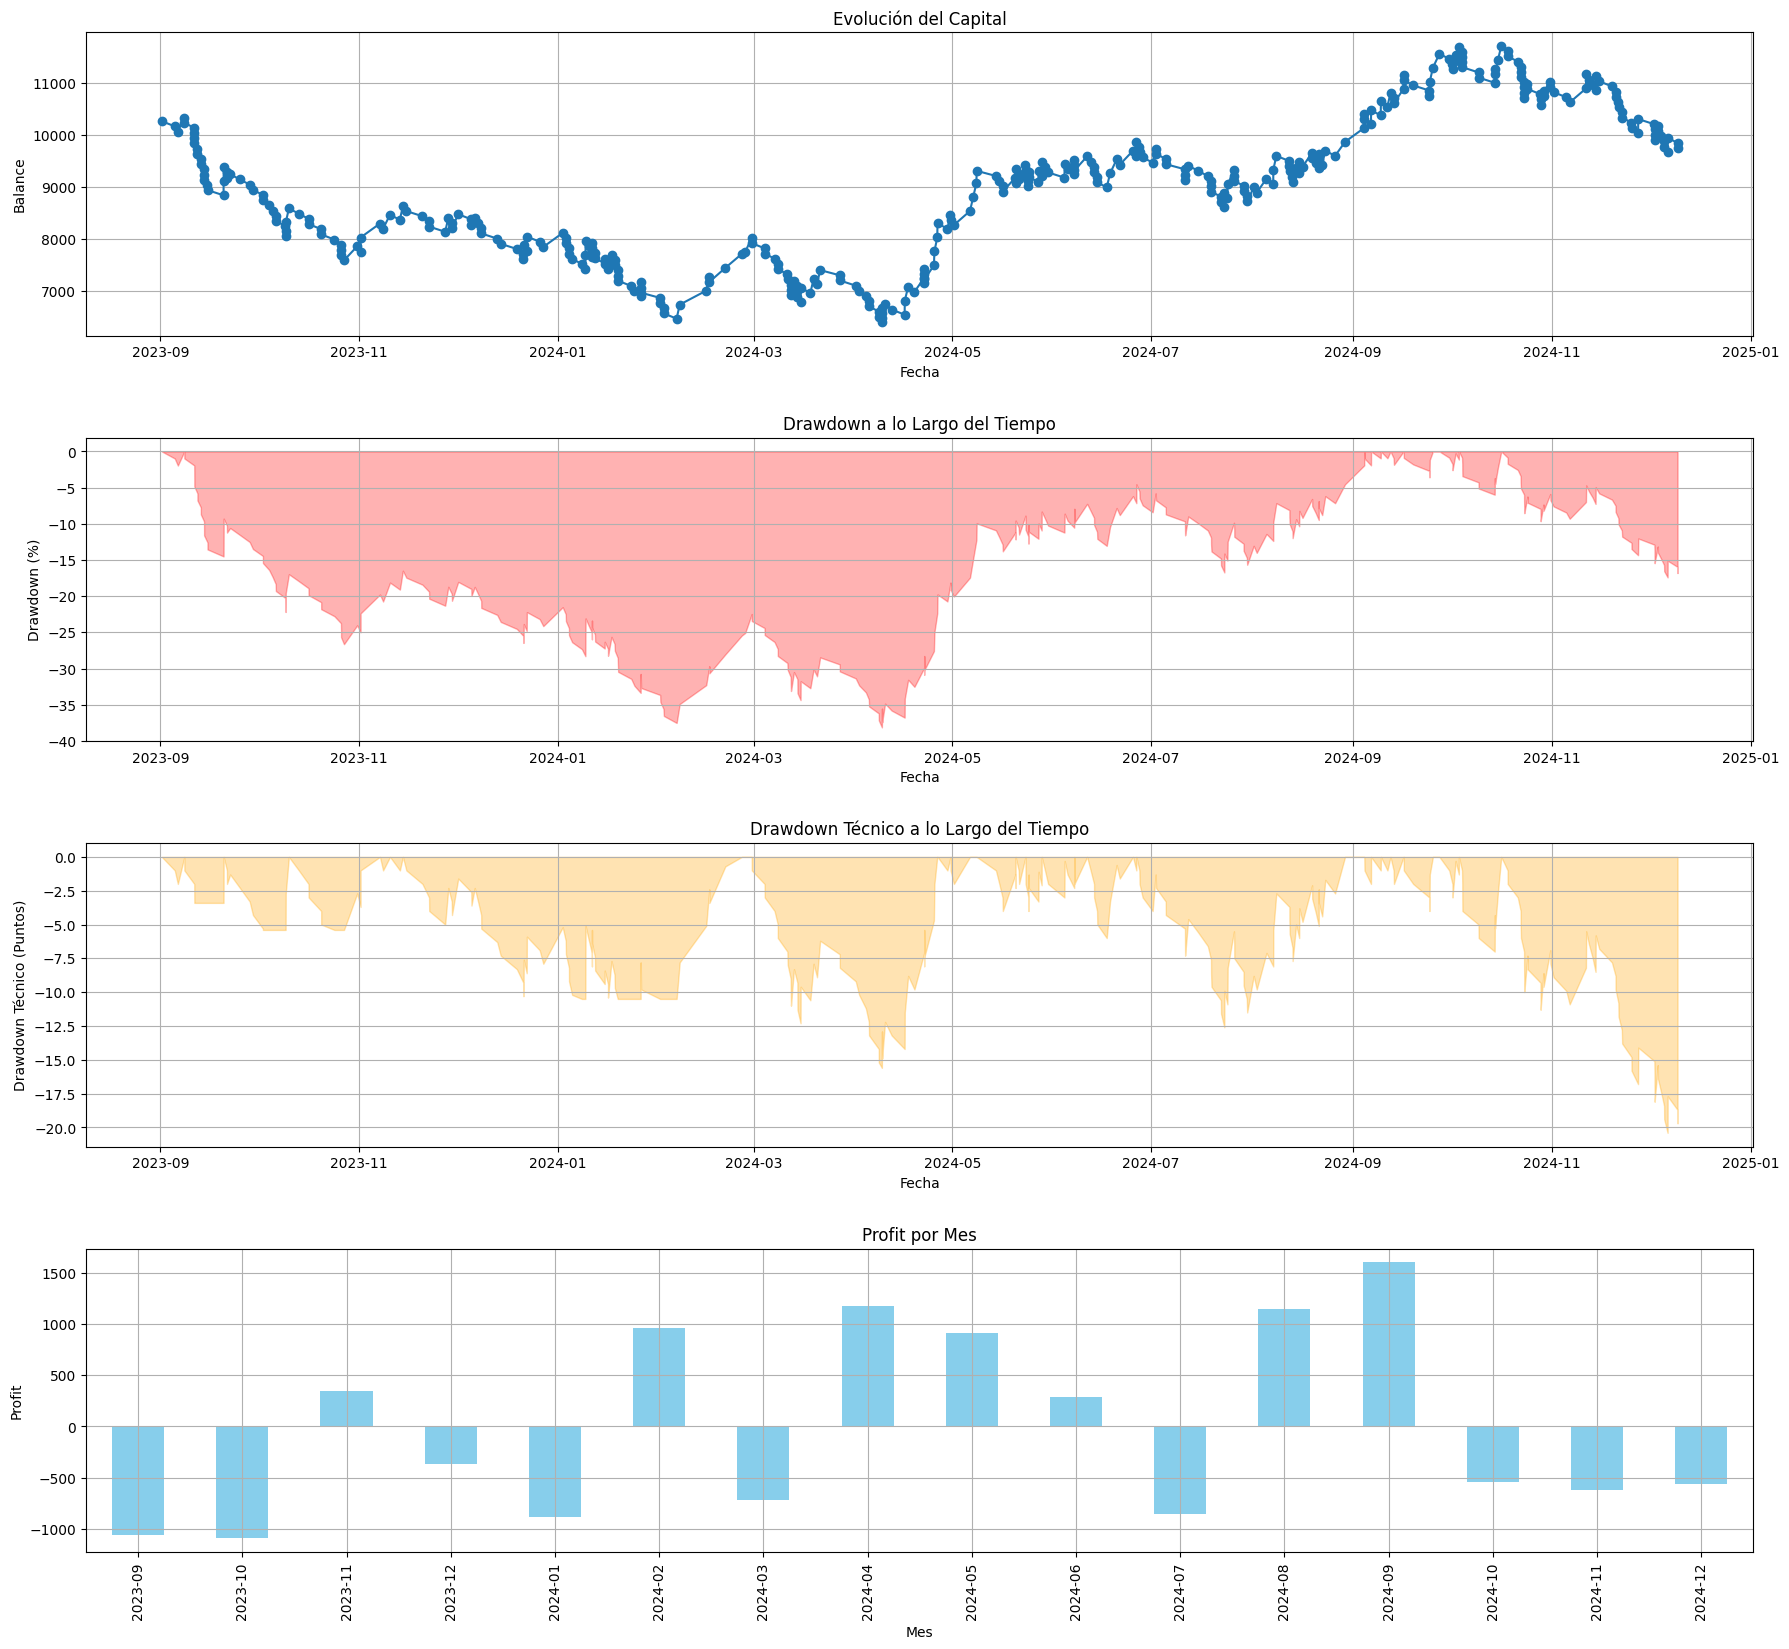

In [5]:
strategy=ApplyStrategy(df2) 
strategy.set_operations(SL=31, TP_multiplier=2.7, start_timeH=8, delta_hour=4,reverse=False)
strategy.get_results(BE = {'enable': False, 'set': 1.5, 'BE_tp': 0.4})
Metris=StrategyMetrics(df_filt=strategy.OnlyOPs, risk_per_trade=1, inicial_balance=10000)
Metris.get_resume()

In [6]:
df_ops=strategy.OPs
df_ops[~df_ops['OP'].isna()].loc['2024-09-02 8:02:00':][['fvg_price','OP','SL','TP_Multiplier','open_price','Result','time_result','pips_driven']].head()
display(df_ops[df_ops['OP']!=0].head(2))

df_time=df_ops[df_ops['OP']!=0][['time_result']]
df_time['time_difference_minutes'] = (df_time['time_result'] - df_time.index).dt.total_seconds() / 60
print('La cantidad de operaciones cerradas en la misma vela donde se abrio es:',df_time[df_time['time_difference_minutes']<1]['time_difference_minutes'].count())

,open,high,low,close,body,fvg_body,fvg_price,porcentaje_fvg,fvg,OP,SL,TP,TP_Multiplier,open_price,Result,time_result,pips_driven
time,,,,,,,,,,,,,,,,,
2023-09-01 11:00:00,34832.7,34847.7,34821.2,34828.2,-4.5,NaN,NaN,NaN,NaN,-1,31.0,34764.00,2.7,34847.70,1,2023-09-01 11:25:00,83.7
2023-09-05 10:30:00,34788.2,34788.7,34741.7,34742.2,-46.0,NaN,NaN,NaN,NaN,1,31.0,34853.95,2.7,34770.25,-1,2023-09-05 10:35:00,-31.0


La cantidad de operaciones cerradas en la misma vela donde se abrio es: 42


In [36]:
import datetime
import os
import tempfile
import shutil
import pandas as pd
from fpdf import FPDF

def generar_grafico_fvg(df, fecha):
    # Convertir la fecha a tipo datetime
    fecha_inicio = datetime.datetime.strptime(fecha, '%Y-%m-%d')
    fecha_fin = fecha_inicio + datetime.timedelta(days=1)
    
    # Filtrar los datos del dataframe para la fecha especificada
    df_dia = df[(df.index >= fecha_inicio) & (df.index < fecha_fin)]
    
    if df_dia.empty:
        print(f"No hay datos para la fecha {fecha}.")
        return None  # Si no hay datos para la fecha, retornar None
    
    # Crear la figura
    fig = make_subplots(rows=1, cols=1)
    
    # Crear el gráfico de velas
    fig.add_trace(go.Candlestick(
        x=df_dia.index,
        open=df_dia['open'],
        high=df_dia['high'],
        low=df_dia['low'],
        close=df_dia['close'],
        name='Candlestick',
        increasing_line_color='green',
        decreasing_line_color='red'
    ))
    
    # Filtrar puntos donde fvg == 1 para el high (verde)
    df_fvg_up = df_dia[df_dia['fvg'] == 1]
    
    # Filtrar puntos donde fvg == -1 para el low (rojo)
    df_fvg_down = df_dia[df_dia['fvg'] == -1]
    
    # Añadir líneas horizontales para FVG Up (verde)
    for idx, row in df_fvg_up.iterrows():
        start_time = idx
        end_time = start_time + datetime.timedelta(minutes=15)
        fig.add_shape(
            type="line",
            x0=start_time,
            y0=row['fvg_price'],
            x1=end_time,
            y1=row['fvg_price'],
            line=dict(color='green', width=2),
            xref='x',
            yref='y'
        )
    
    # Añadir líneas horizontales para FVG Down (rojo)
    for idx, row in df_fvg_down.iterrows():
        start_time = idx
        end_time = start_time + datetime.timedelta(minutes=15)
        fig.add_shape(
            type="line",
            x0=start_time,
            y0=row['fvg_price'],
            x1=end_time,
            y1=row['fvg_price'],
            line=dict(color='red', width=2),
            xref='x',
            yref='y'
        )
    
    # Configurar el layout del gráfico
    fig.update_layout(
        title=f"Gráfico de Velas y FVG para el día {fecha}",
        xaxis_title="Hora",
        yaxis_title="Precio",
        xaxis_rangeslider_visible=False,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        width=1700,  # Ancho del gráfico
        height=900,  # Altura del gráfico
        template='plotly_dark'  # Cambiar el tema a oscuro
    )
    
    # Mostrar el gráfico
    #fig.show()
    return fig


def generar_grafico_por_dia(df, fecha):
    # Convertir la fecha a tipo datetime
    fecha_inicio = datetime.datetime.strptime(fecha, '%Y-%m-%d')
    fecha_fin = fecha_inicio + datetime.timedelta(days=1)
    
    # Filtrar los datos del dataframe para la fecha especificada
    df_dia = df[(df.index >= fecha_inicio) & (df.index < fecha_fin)]
    
    if df_dia.empty:
        print(f"No hay datos para la fecha {fecha}.")
        return None  # Si no hay datos para la fecha, retornar None
    
    # Crear la figura con subplots si deseas agregar más gráficos en el futuro
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
    
    # Crear el gráfico de velas
    fig.add_trace(go.Candlestick(
        x=df_dia.index,
        open=df_dia['open'],
        high=df_dia['high'],
        low=df_dia['low'],
        close=df_dia['close'],
        name='Candlestick',
        increasing_line_color='green',
        decreasing_line_color='red',
        opacity=0.6
    ))
    
    # ============================
    # Agregar Líneas Horizontales para FVG
    # ============================
    
    # Verificar si las columnas 'fvg' y 'fvg_price' existen en el DataFrame
    if 'fvg' in df_dia.columns and 'fvg_price' in df_dia.columns:
        # Filtrar puntos donde fvg == 1 para el high (verde)
        df_fvg_up = df_dia[df_dia['fvg'] == 1]
        
        # Filtrar puntos donde fvg == -1 para el low (rojo)
        df_fvg_down = df_dia[df_dia['fvg'] == -1]
        
        # Añadir líneas horizontales para FVG Up (verde)
        for idx, row in df_fvg_up.iterrows():
            start_time = idx
            end_time = start_time + datetime.timedelta(minutes=15)
            # Asegurarse de que end_time no exceda el rango del gráfico
            if end_time > fecha_fin:
                end_time = fecha_fin
            fig.add_shape(
                type="line",
                x0=start_time,
                y0=row['fvg_price'],
                x1=end_time,
                y1=row['fvg_price'],
                line=dict(color='white', width=2),
                xref='x',
                yref='y'
            )
        
        # Añadir líneas horizontales para FVG Down (rojo)
        for idx, row in df_fvg_down.iterrows():
            start_time = idx
            end_time = start_time + datetime.timedelta(minutes=15)
            # Asegurarse de que end_time no exceda el rango del gráfico
            if end_time > fecha_fin:
                end_time = fecha_fin
            fig.add_shape(
                type="line",
                x0=start_time,
                y0=row['fvg_price'],
                x1=end_time,
                y1=row['fvg_price'],
                line=dict(color='white', width=2),
                xref='x',
                yref='y'
            )
        
    else:
        print("Las columnas 'fvg' y/o 'fvg_price' no existen en el DataFrame.")

    # ============================
    # Agregar Operaciones
    # ============================
    
    # Verificar si la columna 'OP' existe
    if 'OP' in df_dia.columns:
        # Filtrar operaciones de compra y venta
        operaciones = df_dia[df_dia['OP'].isin([1, -1])]
        
        if not operaciones.empty:
            for idx, operation in operaciones.iterrows():
                OP = operation['OP']
                Result = operation['Result']
                entry_time = idx
                entry_price = operation['open_price']
                exit_time = operation['time_result']
                TP_multiplier = operation['TP_Multiplier']
                SL_points = operation['SL']
                pips = operation['pips_driven']
                
                # Calcular TP y SL basados en el tipo de operación
                if OP == 1:
                    # Operación de Compra
                    TP_price = entry_price + (SL_points * TP_multiplier)
                    SL_price = entry_price - SL_points
                    marker_symbol_entry = 'triangle-up'
                elif OP == -1:
                    # Operación de Venta
                    TP_price = entry_price - (SL_points * TP_multiplier)
                    SL_price = entry_price + SL_points
                    marker_symbol_entry = 'triangle-down'
                
                # ============================
                # Agregar Rectángulo para Stop Loss (SL)
                # ============================
                fig.add_shape(
                    type="rect",
                    x0=entry_time,
                    y0=entry_price,  # Ajusta el rango vertical si es necesario
                    x1=exit_time,
                    y1=SL_price,  # Ajusta el rango vertical si es necesario
                    fillcolor='rgba(255, 0, 0, 0.2)',  # Rojo semi-transparente para SL
                    line=dict(color='rgba(255, 0, 0, 0.2)'),
                    layer="below"
                    # No se incluye 'name' para evitar leyendas redundantes
                )
                
                # ============================
                # Agregar Rectángulo para Take Profit (TP)
                # ============================
                fig.add_shape(
                    type="rect",
                    x0=entry_time,
                    y0=entry_price,  # Ajusta el rango vertical si es necesario
                    x1=exit_time,
                    y1=TP_price,  # Ajusta el rango vertical si es necesario
                    fillcolor='rgba(0, 255, 0, 0.2)',  # Verde semi-transparente para TP
                    line=dict(color='rgba(0, 255, 0, 0.2)'),
                    layer="below"
                    # No se incluye 'name' para evitar leyendas redundantes
                )
                
                # ============================
                # Añadir marcador para la entrada
                # ============================
                fig.add_trace(go.Scatter(
                    x=[entry_time],
                    y=[entry_price],
                    mode='markers',
                    marker=dict(color='blue', size=10, symbol=marker_symbol_entry),
                    name='Entrada Compra' if OP == 1 else 'Entrada Venta',
                    showlegend=False
                ))
                
                # ============================
                # Determinar el precio de salida basado en el resultado
                # ============================
                if Result == 1:
                    # Operación Ganada: se alcanzó TP
                    exit_price = TP_price
                    exit_marker_color = 'green'
                    exit_marker_symbol = 'circle'
                    exit_name = 'Salida TP'
                elif Result == -1:
                    # Operación Perdida: se alcanzó SL
                    exit_price = SL_price
                    exit_marker_color = 'red'
                    exit_marker_symbol = 'circle'
                    exit_name = 'Salida SL'
                elif Result == 2:
                    # Operación Break Even
                    exit_price = entry_price
                    exit_marker_color = 'yellow'
                    exit_marker_symbol = 'diamond'
                    exit_name = 'Salida BE'
                else:
                    # Operación cerrada por límite de tiempo u otro
                    if exit_time in df_dia.index:
                        exit_price = df_dia.loc[exit_time]['close']
                    else:
                        exit_price = entry_price
                    exit_marker_color = 'grey'
                    exit_marker_symbol = 'x'
                    exit_name = 'Salida Time Out'
                
                # ============================
                # Añadir marcador para la salida
                # ============================
                fig.add_trace(go.Scatter(
                    x=[exit_time],
                    y=[exit_price],
                    mode='markers',
                    marker=dict(color=exit_marker_color, size=8, symbol=exit_marker_symbol),
                    name=exit_name,
                    showlegend=False
                ))
                
                # ============================
                # Añadir marcador para Break Even si aplica
                # ============================
                if Result == 2:
                    fig.add_trace(go.Scatter(
                        x=[exit_time],
                        y=[exit_price],
                        mode='markers',
                        marker=dict(color='yellow', size=10, symbol='diamond'),
                        name='Break Even',
                        showlegend=False
                    ))
        else:
            print("No hay operaciones de compra o venta para esta fecha.")
    else:
        print("La columna 'OP' no existe en el DataFrame.")
            
    # Configurar el layout del gráfico
    fig.update_layout(
    title=f"Operaciones del día {fecha}",
    xaxis_title="Hora",
    yaxis_title="Precio",
    xaxis_rangeslider_visible=False,
    width=1700,  # Ancho del gráfico
    height=800,  # Altura del gráfico
    template='plotly_dark'  # Cambiar el tema a oscuro
    )
    
    return fig

def generar_pdf(df):
    # Obtener la lista de fechas únicas en el dataframe
    lista_fechas = df.index.normalize().unique()
    
    # Lista para almacenar los nombres de los archivos de imagen
    archivos_imagenes = []
    
    # Crear un directorio temporal para almacenar las imágenes
    temp_dir = tempfile.mkdtemp()
    
    # Dimensiones de las imágenes
    img_width_px = 1600
    img_height_px = 800
    
    # Iterar sobre cada fecha y generar el gráfico correspondiente
    for fecha in lista_fechas:
        fecha_str = fecha.strftime('%Y-%m-%d')
        # Generar el gráfico para la fecha
        fig = generar_grafico_fvg(df, fecha_str)
        
        if fig is None:
            continue  # Si no hay datos para la fecha, continuar con la siguiente
        
        # Guardar el gráfico como imagen
        nombre_imagen = os.path.join(temp_dir, f"{fecha_str}.png")
        fig.write_image(nombre_imagen, format='png', width=img_width_px, height=img_height_px)
        archivos_imagenes.append(nombre_imagen)
    
    if not archivos_imagenes:
        print("No hay gráficos para generar el PDF.")
        shutil.rmtree(temp_dir)
        return None
    
    # Crear el PDF ajustando el tamaño de la página al tamaño de las imágenes
    pdf = FPDF(unit='pt', format=(img_width_px, img_height_px))
    
    for archivo_imagen in archivos_imagenes:
        pdf.add_page()
        pdf.image(archivo_imagen, x=0, y=0, w=img_width_px, h=img_height_px)
    
    # Eliminar el directorio temporal
    shutil.rmtree(temp_dir)
    
    return pdf

def guardar_pdf(pdf, nombre_pdf):
    # Guardar el PDF en el directorio actual
    if pdf is not None:
        pdf.output(nombre_pdf, "F")
        print(f"Archivo PDF '{nombre_pdf}' guardado con éxito en el directorio actual.")
    else:
        print("No se generó ningún PDF para guardar.")

# Generar gráfico para la fecha 2021-01-04
generar_grafico_fvg(df2, '2024-12-10')

In [16]:
try:
    Fecha=None#'2024-12-09'
    fechas=strategy.OPs[strategy.OPs['Result']==-2].index.strftime('%Y-%m-%d').unique().tolist()[-1]
    grafico=generar_grafico_por_dia(strategy.OPs,Fecha) if Fecha is not None else generar_grafico_por_dia(strategy.OPs,fechas)
    grafico.show()
except:
    print('Fuera de rango')

In [18]:
pdf = generar_pdf(df2)

In [19]:
guardar_pdf(pdf, 'graficos_diarios.pdf')

Archivo PDF 'graficos_diarios.pdf' guardado con éxito en el directorio actual.
